In [1]:
%matplotlib notebook

import os
import sys
import time

import numpy as np
import pandas as pd
import qgrid
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import madmom
from madmom.features.beats import DBNBeatTrackingProcessor
from madmom.features.beats import RNNBeatProcessor

import IPython.display as ipd
from librosa import clicks
from scipy.io import wavfile

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from python.post_processing import activations2beats
from python.models import ModelBoeck
from python.utils import *

## Load data and model

In [2]:
data = pd.read_csv('../data/data.csv', index_col=0)

print('Torch version: {}'.format(torch.__version__))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: %s' % (device))

model = ModelBoeck()
model.load_state_dict(torch.load('../models/mb_ballroom_bs-100_fold-0.pt', map_location=device))
model.eval()

Torch version: 1.0.0
Device: cpu


ModelBoeck(
  (lstm): LSTM(120, 25, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

## Calculate predictions

In [6]:
# files = data['file'][data['data_set'] == 2]
files = data['file']

start = time.time()
for nr, file in enumerate(files):
    i = files.index[nr]

    print('Evaluate file {} of {}'.format(nr+1, len(files)), end="\r")

    input = get_input(data.at[i,'file'])

    with torch.no_grad():        
        out = model(input.view(1, len(input),-1))

    activations = np.exp(np.array(out[0,1,:]))

    pred_beats = activations2beats(activations)

    np.savetxt('../data/predictions/' + file + '.beats', pred_beats,  fmt='%.2f ')

## Evaluation

In [3]:
# Eval Functions

def onset_evaluation(detections, annotations, window=0.025):
    # make sure the arrays have the correct types and dimensions
    detections = np.asarray(detections, dtype=np.float)
    annotations = np.asarray(annotations, dtype=np.float)
    # TODO: right now, it only works with 1D arrays
    if detections.ndim > 1 or annotations.ndim > 1:
        raise NotImplementedError('please implement multi-dim support')

    # init TP, FP, FN and errors
    tp = np.zeros(0)
    fp = np.zeros(0)
    tn = np.zeros(0)  # we will not alter this array
    fn = np.zeros(0)
    errors = np.zeros(0)

    # if neither detections nor annotations are given
    if len(detections) == 0 and len(annotations) == 0:
        # return the arrays as is
        return tp, fp, tn, fn, errors
    # if only detections are given
    elif len(annotations) == 0:
        # all detections are FP
        return tp, detections, tn, fn, errors
    # if only annotations are given
    elif len(detections) == 0:
        # all annotations are FN
        return tp, fp, tn, annotations, errors

    # window must be greater than 0
    if float(window) <= 0:
        raise ValueError('window must be greater than 0')

    # sort the detections and annotations
    det = np.sort(detections)
    ann = np.sort(annotations)
    # cache variables
    det_length = len(detections)
    ann_length = len(annotations)
    det_index = 0
    ann_index = 0
    # iterate over all detections and annotations
    while det_index < det_length and ann_index < ann_length:
        # fetch the first detection
        d = det[det_index]
        # fetch the first annotation
        a = ann[ann_index]
        # compare them
        if abs(d - a) <= window:
            # TP detection
            tp = np.append(tp, d)
            # append the error to the array
            errors = np.append(errors, d - a)
            # increase the detection and annotation index
            det_index += 1
            ann_index += 1
        elif d < a:
            # FP detection
            fp = np.append(fp, d)
            # increase the detection index
            det_index += 1
            # do not increase the annotation index
        elif d > a:
            # we missed a annotation: FN
            fn = np.append(fn, a)
            # do not increase the detection index
            # increase the annotation index
            ann_index += 1
        else:
            # can't match detected with annotated onset
            raise AssertionError('can not match % with %', d, a)
    # the remaining detections are FP
    fp = np.append(fp, det[det_index:])
    # the remaining annotations are FN
    fn = np.append(fn, ann[ann_index:])
    # check calculations
    if len(tp) + len(fp) != len(detections):
        raise AssertionError('bad TP / FP calculation')
    if len(tp) + len(fn) != len(annotations):
        raise AssertionError('bad FN calculation')
    if len(tp) != len(errors):
        raise AssertionError('bad errors calculation')
    # convert to numpy arrays and return them
    return np.array(tp), np.array(fp), tn, np.array(fn), np.array(errors)


def num_tp(detections, annotations):

    return len(onset_evaluation(detections, annotations)[0])


def num_fp(detections, annotations):

    return len(onset_evaluation(detections, annotations)[1])


def num_tn(detections, annotations):

    return len(onset_evaluation(detections, annotations)[2])


def num_fn(detections, annotations):

    return len(onset_evaluation(detections, annotations)[3])


def precision(detections, annotations):
    # correct / retrieved
    retrieved = float(num_tp(detections, annotations) + num_fp(detections, annotations))
    # if there are no positive predictions, none of them are wrong
    if retrieved == 0:
        return 1.
    return num_tp(detections, annotations) / retrieved


def recall(detections, annotations):
    """Recall."""
    # correct / relevant
    relevant = float(num_tp(detections, annotations) + num_fn(detections, annotations))
    # if there are no positive annotations, we recalled all of them
    if relevant == 0:
        return 1.
    return num_tp(detections, annotations) / relevant


def fmeasure(detections, annotations):
    """F-measure."""
    # 2pr / (p+r)
    numerator = 2. * precision(detections, annotations) * recall(detections, annotations)
    if numerator == 0:
        return 0.
    return numerator / (precision(detections, annotations) + recall(detections, annotations))


def accuracy(detections, annotations):
    """Accuracy."""
    # acc: (TP + TN) / (TP + FP + TN + FN)
    denominator = num_fp(detections, annotations) + num_fn(detections, annotations) \
        + num_tp(detections, annotations) + num_tn(detections, annotations)
    if denominator == 0:
        return 1.
    numerator = float(num_tp(detections, annotations) + num_tn(detections, annotations))
    if numerator == 0:
        return 0.
    return numerator / denominator


def calc_absolute_errors(detections, annotations):
    
    return np.abs(calc_errors(detections, annotations))


def calc_errors(detections, annotations):

    if len(detections) == 0 or len(annotations) == 0:
        return np.zeros(0, dtype=np.float)
    
    # determine the closest annotations
    matches = find_closest_matches(detections, annotations)
    
    # calc error relative to those annotations
    errors = detections - annotations[matches]

    return errors


def find_closest_matches(detections, annotations):
    
    # if no detections or annotations are given
    if len(detections) == 0 or len(annotations) == 0:
        return np.zeros(0, dtype=np.int)

    if len(annotations) == 1:
        # return an array as long as the detections with indices 0
        return np.zeros(len(detections), dtype=np.int)

    indices = annotations.searchsorted(detections)
    indices = np.clip(indices, 1, len(annotations) - 1)
    left = annotations[indices - 1]
    right = annotations[indices]
    indices -= detections - left < right - detections
    # return the indices of the closest matches
    return indices


def pscore(detections, annotations, tolerance=0.2):
    # at least 2 annotations must be given to calculate an interval
    if len(annotations) < 2:
        raise BeatIntervalError("At least 2 annotations are needed for"
                                "P-Score.")
    # tolerance must be greater than 0
    if float(tolerance) <= 0:
        raise ValueError("`tolerance` must be greater than 0.")
    # the error window is the given fraction of the median beat interval
    window = tolerance * np.median(np.diff(annotations))
    # errors
    errors = calc_absolute_errors(detections, annotations)
    # count the instances where the error is smaller or equal than the window
    p = len(detections[errors <= window])
    # normalize by the max number of detections/annotations
    p /= float(max(len(detections), len(annotations)))
    # return p-score
    return p

In [9]:
old_predictions = get_predictions(data.at[1, 'file'], 'old')
predictions = get_predictions(data.at[1, 'file'])

<IPython.core.display.Javascript object>


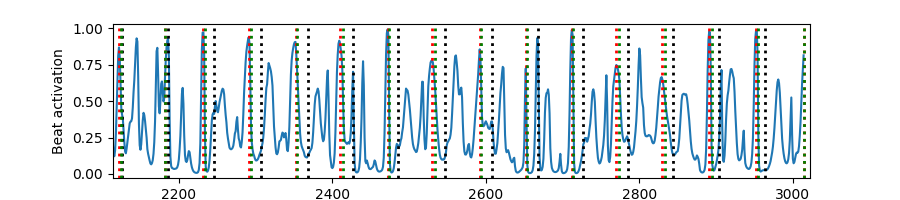

In [28]:
show_activations(data.at[1,'file'], model)
for ann in old_predictions:
    plt.axvline(x=ann*100, color='g', linestyle=':', linewidth=2)

In [3]:
play_annotations(data.at[1,'file'], section=(2000, 3000))

In [26]:
100/10*5

50.0

In [50]:
qgrid.show_grid(data)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## P Score

In [5]:
data.rename(columns={'p_score': 'p_score_old'}, inplace=True)

In [40]:
files = data['file']
start = time.time()
for nr, file in enumerate(files):
    i = files.index[nr]
    
    print("Progress file {:d} of {:d}".format(nr+1, len(files)), end="\r")
    
    annotations = get_annotations(data.at[i,'file'])
    predictions = get_predictions(data.at[i,'file'], subfolder='madmom')
        
    data.at[i,'p_madmom'] = pscore(predictions, annotations)
     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

Progress file 915 of 915
Elapsed time: 0 min and 3 s


## F Measure

In [7]:
data.rename(columns={'f_measure': 'f_measure_old'}, inplace=True)

In [41]:
files = data['file']

start = time.time()
for nr, file in enumerate(files):
    i = files.index[nr]
    
    print("Progress file {:d} of {:d}".format(nr+1, len(files)), end="\r")
    
    annotations = get_annotations(data.at[i,'file'])
    predictions = get_predictions(data.at[i,'file'], subfolder='madmom')
        
    data.at[i,'f_madmom'] = fmeasure(predictions, annotations)
     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

Progress file 915 of 915
Elapsed time: 0 min and 17 s


In [37]:
# Madmom results

# files = data['file']

# proc = DBNBeatTrackingProcessor(fps=100)

# start = time.time()
# for nr, file in enumerate(files):
#     i = files.index[nr]
    
#     print('Evaluate file {} of {}'.format(nr+1, len(files)), end="\r")

#     act = RNNBeatProcessor()('../data/audio/' + file + '.wav')
#     pred_beats = proc(act)

#     np.savetxt('../data/predictions/madmom/' + file + '.beats', pred_beats,  fmt='%.2f ')
    
# end = time.time()
# print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

/Users/juliusrichter/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Evaluate file 915 of 915
Elapsed time: 230 min and 1 s


## Example

<IPython.core.display.Javascript object>


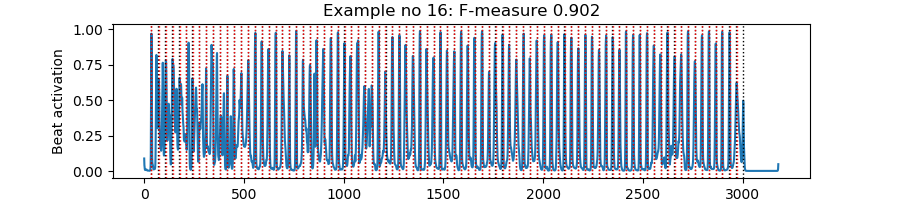

In [23]:
show_activations(data.at[16,'file'], model)

In [43]:
np.mean(data['p_madmom'][data['data_set'] == 1])

0.875379608670366

## Save data

In [44]:
data.to_csv('../data/data.csv')